In [245]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '../vision_fit'))  # insert parent path
import time
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
import torchvision.models as models
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import style
import stats
sys.path.append('/accounts/projects/vision/chandan/max_activation_interpretation_pytorch/')
import max_act
from model_helpers import Model_feats
import visualize_ims as viz
from visualize_ims import im_to_np, get_im
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
style.set_style()
import warnings
warnings.filterwarnings("ignore")

In [20]:
import foolbox

# compare when models differ

In [194]:
device = 'cuda'
m1 = models.densenet121(pretrained=True).eval().to(device)
m2 = models.vgg11(pretrained=True).eval().to(device)

**do they correlate on gaussian images?**

In [226]:
n = 500

# get preds
preds1 = np.zeros((n, 1000))
preds2 = np.zeros((n, 1000))
for i in range(n):
    x = torch.randn(1, 3, 224, 224).to(device)
    pred1 = m1(x).detach().cpu()
    pred2 = m2(x).detach().cpu()
    preds1[i] = pred1.flatten()
    preds2[i] = pred2.flatten()

In [234]:
def simple_stats(preds1, preds2):
    # flattened corrs
    flattened_corr = stats.corr(preds1, preds2)

    # class corrs
    class_corrs = np.zeros(1000)
    for lab_num in range(1000):
        class_corrs[lab_num] = stats.corr(preds1[:, lab_num], preds2[:, lab_num])
    class_corr = np.mean(class_corrs)
    print(f'flattened_corr: {flattened_corr:0.3f} class_corr: {class_corr:0.3f}')

In [227]:
simple_stats(preds1, preds2)

flattened_corr: 0.673 class_corr: 0.012


**do they correlate on imagenet?**

In [240]:
root = '/scratch/users/vision/data/cv/imagenet_full'
dset_name = 'val/val' # train or val/val
dset_val = dset.ImageFolder(oj(root, dset_name), 
                            transforms.Compose([transforms.Resize(256),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                viz.normalize]))

In [241]:
n = 100

# get preds
preds1 = np.zeros((n, 1000))
preds2 = np.zeros((n, 1000))
labs = np.zeros(n)
for i in range(n):
    idx = np.random.randint(0, 50000)
    x = dset_val[idx][0].unsqueeze(0).to(device)
    labs[i] = dset_val[idx][1]
    pred1 = m1(x).detach().cpu()
    pred2 = m2(x).detach().cpu()
    preds1[i] = pred1.flatten()
    preds2[i] = pred2.flatten()

In [250]:
print(simple_stats(preds1, preds2))
print(stats.calc_corrs(preds1, preds2, labs))

flattened_corr: 0.763 class_corr: 0.734
None
both correct 66
{'raw_corr': 0.7632752626960633, 'intra_class_corr_all': 0.7811195468107336, 'intra_class_corr_correct': 0.7755171178300015, 'intra_class_corr_column': 1.0, 'intra_class_rank_corr': 0.7041787720210766}


**do they correlate on imagenet adversarial examples?**

In [232]:
n = 100

# set up attack
fmodel = foolbox.models.PyTorchModel(m1, 
                                 bounds=(0, 1), 
                                 num_classes=1000)
attack = foolbox.attacks.FGSM(fmodel)

# get preds
preds1 = np.zeros((n, 1000))
preds2 = np.zeros((n, 1000))
for i in tqdm(range(n)):
#     x = torch.randn(1, 3, 224, 224).to(device)
    _, x = get_im(dset_val, i)
    x = (x - x.min()) / (x.max() - x.min())
    lab = dset_val[i][1]

    x_adv = attack(x.detach().cpu().numpy().squeeze(), lab)
    x.data = torch.Tensor(x_adv).unsqueeze(0).to(device)
    
    pred1 = m1(x).detach().cpu()
    pred2 = m2(x).detach().cpu()
    preds1[i] = pred1.flatten()
    preds2[i] = pred2.flatten()

100%|██████████| 100/100 [01:17<00:00,  1.40it/s]


In [235]:
simple_stats(preds1, preds2)

flattened_corr: 0.666 class_corr: 0.470


## generate adv example demonstration

In [253]:
im_num = i
im_np, im_torch = get_im(dset_val, im_num)
preds = m1(im_torch.to(device))
topk, indices = torch.topk(preds, 5)
print('pred class', indices, 'lab', dset_val[im_num][1])
    
# viz.show(im_np)

pred class tensor([[107, 396, 115,   1, 983]], device='cuda:0') lab 1


In [254]:
x = im_torch.to(device) #dset_val[im_num][0].unsqueeze(0).to(device)
# x = dset_val[im_num][0].unsqueeze(0).to(device)
x = (x - x.min()) / (x.max() - x.min())
lab = dset_val[im_num][1]
print('label', lab, 'pred', m1(x).softmax(dim=1).argmax().item())
fmodel = foolbox.models.PyTorchModel(m1, 
                                     bounds=(0, 1), 
                                     num_classes=1000)
attack = foolbox.attacks.FGSM(fmodel)
x_adv = attack(x.detach().cpu().numpy().squeeze(), lab)
print('adv', np.argmax(fmodel.predictions(x_adv)))

label 1 pred 1
adv 29


torch.Size([1, 3, 224, 224]) (3, 224, 224)


<Figure size 600x400 with 0 Axes>

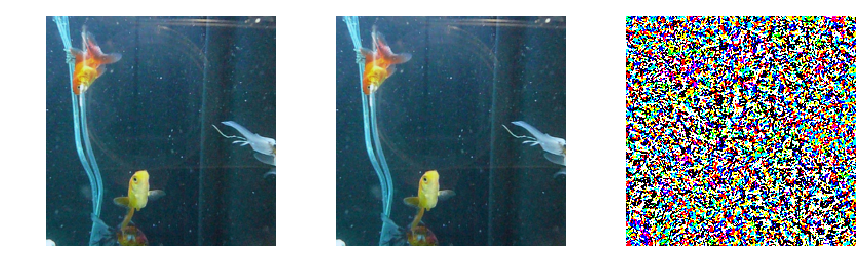

In [255]:
print(x.shape, x_adv.shape)
viz.show([x, x_adv, x.detach().cpu().squeeze().numpy() - x_adv])
plt.show()

# hard-coded generalization plot

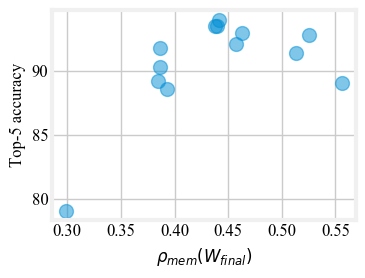

In [19]:
max_corr_dir = '/accounts/projects/vision/scratch/yu_dl/raaz.rsk/max_corrs'
fnames = os.listdir(max_corr_dir)
corrs = {}
R, C = 2, 2
print_fc1 = True
model_names_list = [['alexnet', 'inception_v3'],
               ['vgg11', 'vgg13', 'vgg16', 'vgg19'],
#                ['vgg16'],
               ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152'],                    
               ['densenet121', 'densenet169', 'densenet201']]

plt.figure(figsize=(4, 3), dpi=100)
rho_mem = [0.299, 
           0.393, 0.385, 0.386, 0.386,
           0.556, 0.513, 0.525, 0.438, 0.441,
           0.457, 0.463, 0.440]
test_acc = 100 - np.array([20.91, 
            11.37, 10.75, 9.62, 8.15,
            10.92, 8.58, 7.13, 6.44, 5.94,
            7.83, 7.00, 6.43])

plt.plot(rho_mem, test_acc, 'o')
plt.xlabel('$\\rho_{mem}(W_{final})$')
plt.ylabel('Top-5 accuracy')
plt.tight_layout()
plt.savefig('generalization.pdf')
plt.show()